# A quantum-inspired graph kernel for graph classification by SVMs

In [121]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import svm

from graph_kernel import (
    dist_from_graph, 
    jensen_shannon, 
    triangular_random_walk, 
    triangular_lattice_draw
)

I've been exploring a graph kernel inspired by the method in https://arxiv.org/abs/2211.16337. Unlike their method, however, what I am doing is completely classical, not quantum.

Given a graph $G$, the method prepares a probability distribution $p_G(n)$ over the nonnegative integers. We can compare two graphs by comparing their resulting distributions. A typical way to compare two distributions is with the Jensen-Shannon divergence. This leads to a family of graph kernels
$$
K(G_1, G_2) = e^{-\gamma \operatorname{JS}(p_{G_1}, p_{G_2})}
$$
which can be used in an SVM to classify graphs.

I've coded up the a function `dist_from_graph()` that prepares a probability distribution from a given graph. I'm using the networkx package to define and work with graphs.

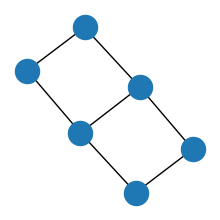

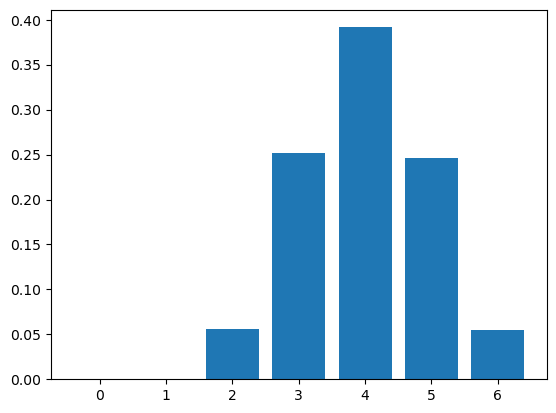

In [75]:
# Make a graph
G = nx.Graph()
G.add_edges_from([(0, 1), (2, 3), (4, 5), (0,2), (3, 5), (1, 3), (2, 4)])

# Draw the graph
fig = plt.figure(figsize=(2, 2))
nx.draw(G)
plt.show()

# Define a probability distribution from the graph
dist = dist_from_graph(G, num_layers=9, shots=1024)

# Plot the distribution
plt.bar(range(G.number_of_nodes() + 1), dist)
plt.show()


Different graphs (potentially) result in different distributions. Let's make two graphs that have different distributions.

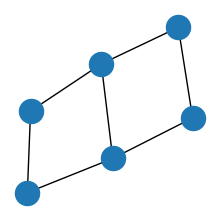

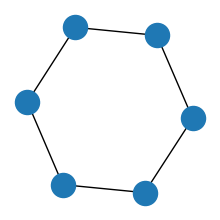

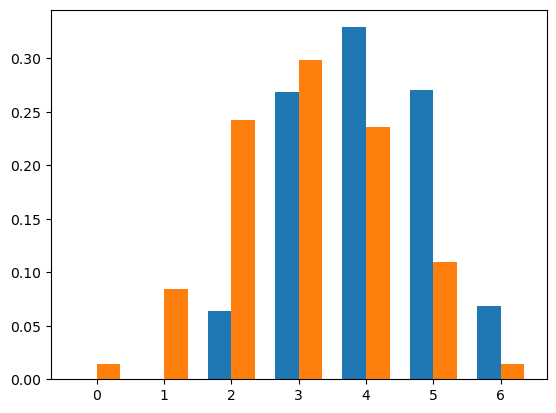

In [76]:
# Make two graphs
G1 = nx.Graph()
G1.add_edges_from([(0, 1), (2, 3), (4, 5), (0,2), (3, 5), (1, 3), (2, 4)])
G2 = nx.Graph()
G2.add_edges_from([(0, 1), (4, 5), (0,2), (3, 5), (1, 3), (2, 4)])

# Draw the graphs
fig = plt.figure(figsize=(2, 2))
nx.draw(G1)
plt.show()
fig = plt.figure(figsize=(2, 2))
nx.draw(G2)
plt.show()

# Define a probability distribution from the graph
dist1 = dist_from_graph(G1, num_layers=9, shots=1024)
dist2 = dist_from_graph(G2, num_layers=9, shots=1024)

# Plot the distributions
bar_width = 0.35
x_pos = np.arange(len(dist1))
plt.bar(x_pos, dist1, width=bar_width, label='G1')
plt.bar(x_pos + bar_width, dist2, width=bar_width, label='G2')
plt.xticks(x_pos + bar_width/2, range(len(dist1)))
plt.show()

Note the different distributions for the graphs G1 and G2. Let's define a kernel from this and calculate the kernel element between G1 and G2:

In [110]:
# Define kernel function
def graph_kernel(graph1, graph2, coeff=40):
    dist1 = dist_from_graph(graph1, num_layers=9, shots=1024)
    dist2 = dist_from_graph(graph2, num_layers=9, shots=1024)
    return np.exp(-coeff*jensen_shannon(dist1, dist2))

# Calculate kernel between G1 and G2
graph_kernel(G1, G2)

0.01284261217608018

## Synthetic data

In https://arxiv.org/abs/2211.16337 they test their kernel on synthetic data (see section III.F on page 8). I want to test our method the same way. Their data is 400 graphs made from random walks on a triangular lattice. Within the triangular lattice is a "preferred" sublattice that the random walk will preferentially go to. There are two choices for this preferred sublattice, a hexagonal sublattice and a kagome sublattice. They generate 200 random walks with the preferred hexagonal sublattice and 200 with the preferred kagome sublattice. They want to distinguish between graphs prepared with the hexagonal sublatice and graphs prepared with the kagome sublattice.

I've coded up a function `triangular_random_walk()` which creates graphs this same way. Let's recreate a dataset like they do:

In [115]:
N = 400 # Total number of graphs
num_nodes = 20 # Number of nodes in each graph

y = np.zeros(N)
num_layers = 5
shots = 1024
p = 0.0 # Probability of accepting a non-preferred vertex to the random walk

graph_list = []
for i in range(N//2):
    graph = triangular_random_walk(num_nodes, p, sublattice='honeycomb')
    graph_list.append(graph)
    y[i] = 1
for i in range(N//2, N):
    graph = triangular_random_walk(num_nodes, p, sublattice='kagome')
    graph_list.append(graph)
    y[i] = 0

`graph_list` is a list of 400 networkx graphs. Let's visualize some of them

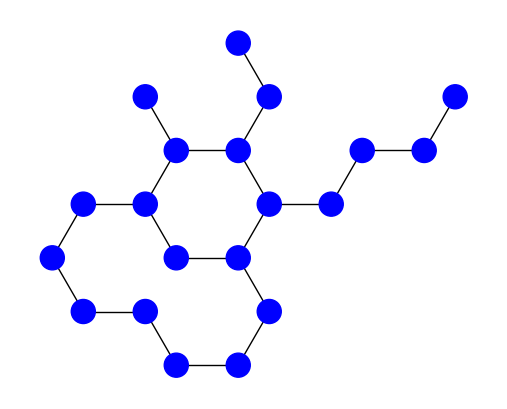

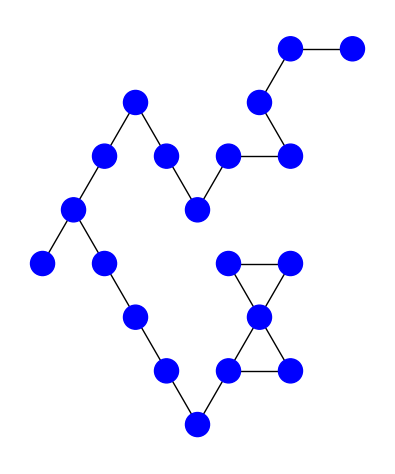

In [116]:
# Visualize a graph from the hexagonal sublattice
triangular_lattice_draw(graph_list[10])

# Visualize a graph from the kagome sublattice
triangular_lattice_draw(graph_list[210])

Let's now use `dist_from_graph()` to change the graphs into probability distributions. We'll also split the datapoints into testing and training sets.

In [118]:
X = np.zeros((N, num_nodes + 1))
for i, graph in enumerate(graph_list):
    X[i] = dist_from_graph(graph, num_layers=9, shots=1024)
    print(f'Prepared distribution from graph {i + 1}/{N}', end='\r')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## SVM

Let's try to classify the distributions `X` using an SVM. We prepare a custom kernel using the Jensen-Shannon divergence, then use this kernel to make an SVM using the sklearn package svm module.

In [140]:
# Define a kernel function for the distributions we've made
def kernel_function(X1, X2, coeff=40):
    kernel = np.zeros((X1.shape[0], X2.shape[0]))
    for i, j in np.ndindex(kernel.shape):
        kernel[i, j] = np.exp(-coeff*jensen_shannon(X1[i], X2[j]))
    return kernel

# Make SVM from our kernel function
graph_svm = svm.SVC(kernel=kernel_function)

# Train it
graph_svm.fit(X_train, y_train)

# Test it
y_predicted = graph_svm.predict(X_test)
accuracy = np.mean(y_predicted == y_test)
print(accuracy)

0.6


Clearly we can do better. We can optimize the method used to generate the distributions form graphs by changing the `num_layers` variable or by changing other things internal to `dist_from_graph()`. We can also change the regularizer parameter C of the SVM or the coefficient in the exponent of our kernel function.

Let's iterate over different values of C.

In [143]:
accuracies = []
exp_range = np.arange(-5, 5, 0.25)
for c in exp_range:
    graph_svm = svm.SVC(kernel=kernel_function, C=np.exp(c))
    graph_svm.fit(X_train, y_train)
    y_predicted = graph_svm.predict(X_test)
    accuracy = np.mean(y_predicted == y_test)
    accuracies.append(accuracy)
    print(f'accuracy for C={np.exp(c)}: {accuracy}' + ' '*30)

accuracy for C=0.006737946999085467: 0.4625                              
accuracy for C=0.008651695203120634: 0.4625                              
accuracy for C=0.011108996538242306: 0.4625                              
accuracy for C=0.014264233908999256: 0.4625                              
accuracy for C=0.01831563888873418: 0.4625                              
accuracy for C=0.023517745856009107: 0.4625                              
accuracy for C=0.0301973834223185: 0.4875                              
accuracy for C=0.03877420783172201: 0.6125                              
accuracy for C=0.049787068367863944: 0.5875                              
accuracy for C=0.06392786120670757: 0.575                              
accuracy for C=0.0820849986238988: 0.55                              
accuracy for C=0.10539922456186433: 0.5625                              
accuracy for C=0.1353352832366127: 0.5625                              
accuracy for C=0.17377394345044514: 0.5625         

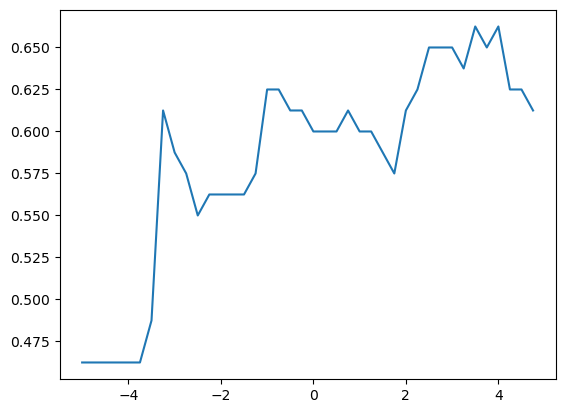

In [144]:
plt.plot(exp_range, accuracies)
plt.show()